In [1]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import yaml
from PIL import Image
from collections import deque

In [2]:
import ultralytics
from ultralytics import YOLO
ultralytics.__version__

'8.3.0'

In [5]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')

In [15]:
# Define the apth to the dataset
dataset_path = './datasets/potholes/final/'

# Define the path to the directory
post_training_files_path = './runs/segment/train'

# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)



## some high level work!

In the case of potholes for roads, you want to measure the percentage of damaged road. Thus, you need to calculate that using the amount of pixeles of you segmentation.


If the model is not good enought, maybe the plot will fail due to no results.


image 1/1 d:\JOBS\lemonio-building\research\datasets\potholes\final\valid\images\img-1267.jpg: 640x640 3 Potholes, 42.5ms
Speed: 6.8ms preprocess, 42.5ms inference, 112.1ms postprocess per image at shape (1, 3, 640, 640)


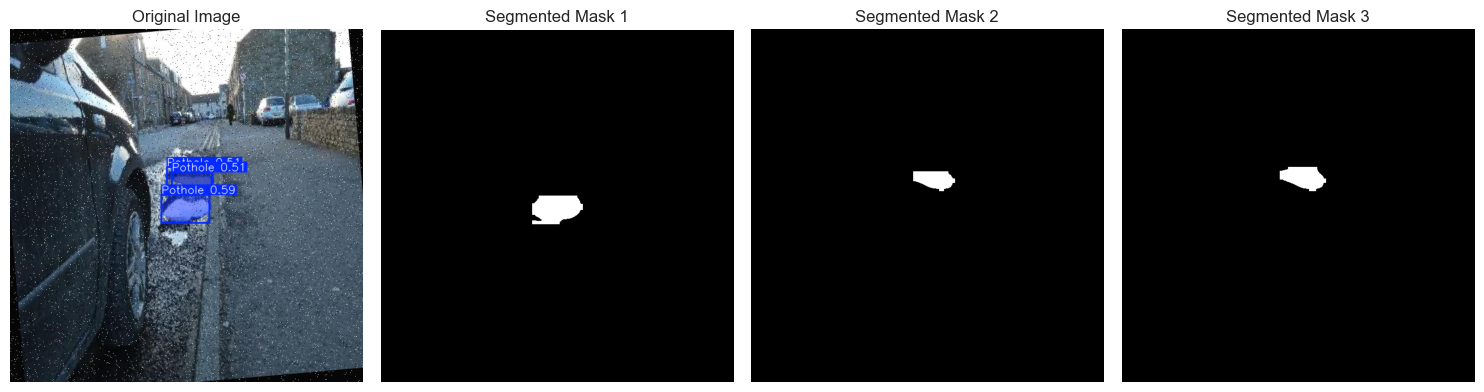

In [16]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select a sample image
selected_image = image_files[45]

# Perform inference on the selected image
image_path = os.path.join(valid_images_path, selected_image)
results = best_model.predict(source=image_path, imgsz=640, conf=0.5)
annotated_image = results[0].plot()
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Determine the number of subplots needed (1 original + number of masks)
num_subplots = 1 + (len(results[0].masks.data) if results[0].masks is not None else 0)

# Initialize the subplot with 1 row and n columns
fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))

# Ensure axes is always a list
if num_subplots == 1:
    axes = [axes]
    
# Display the original annotated image
axes[0].imshow(annotated_image_rgb, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# If multiple masks, iterate and display each mask
if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()
    for i, mask in enumerate(masks):
        # Threshold the mask to make sure it's binary
        # Any value greater than 0 is set to 255, else it remains 0
        binary_mask = (mask > 0).astype(np.uint8) * 255
        axes[i+1].imshow(binary_mask, cmap='gray')
        axes[i+1].set_title(f'Segmented Mask {i+1}')
        axes[i+1].axis('off')

# Adjust layout and display the subplot
plt.tight_layout()
plt.show()



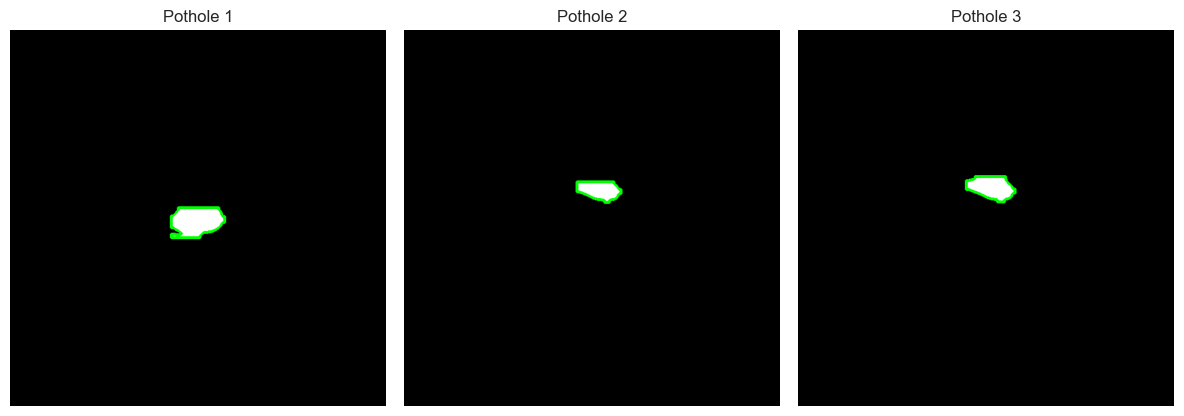

Area of Pothole 1: 3723.0 pixels
Area of Pothole 2: 1877.0 pixels
Area of Pothole 3: 2468.5 pixels
--------------------------------------------------
Total Damaged Area by Potholes: 8068.5 pixels
Total Pixels in Image: 409600 pixels
Percentage of Road Damaged: 1.97%


In [17]:
# Initialize variables to hold total area and individual areas
total_area = 0
area_list = []

# Set up the subplot for displaying masks
fig, axes = plt.subplots(1, len(masks), figsize=(12, 8))

# Perform operations if masks are available
if results[0].masks is not None:
    masks = results[0].masks.data.cpu().numpy()   # Retrieve masks as numpy arrays
    image_area = masks.shape[1] * masks.shape[2]  # Calculate total number of pixels in the image
    for i, mask in enumerate(masks):
        binary_mask = (mask > 0).astype(np.uint8) * 255  # Convert mask to binary
        color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)  # Convert binary mask to color
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the binary mask
        contour = contours[0]  # Retrieve the first contour
        area = cv2.contourArea(contour)  # Calculate the area of the pothole
        area_list.append(area)  # Append area to the list
        cv2.drawContours(color_mask, [contour], -1, (0, 255, 0), 3)  # Draw the contour on the mask

        # Display the mask with the green contour
        axes[i].imshow(color_mask)
        axes[i].set_title(f'Pothole {i+1}')
        axes[i].axis('off')

# Display all masks
plt.tight_layout()
plt.show()

# Calculate and print areas after displaying the images
for i, area in enumerate(area_list):
    print(f"Area of Pothole {i+1}: {area} pixels")  
    total_area += area  # Sum the areas for total

# Calculate and print the total damaged area and percentage of road damaged by potholes
print("-"*50)
print(f"Total Damaged Area by Potholes: {total_area} pixels")
print(f"Total Pixels in Image: {image_area} pixels")
print(f"Percentage of Road Damaged: {(total_area / image_area) * 100:.2f}%")